In [14]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, plot_coverage, print_forecasts_by_week, forecast_by_week
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset,StepStrategy
config = Configuration()
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')
population_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/PopulationVector.csv", sep=',')
neighbourhood_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/AdjacentMatrix.csv", sep=',', index_col=0)

c:\Users\555ka\Coding\GIT-Projects\DeepAR_InfluenzaForecast
c:\Users\555ka\Coding\GIT-Projects\DeepAR_InfluenzaForecast


SyntaxError: 'yield' inside list comprehension (dataloader.py, line 278)

# WITHOUT FEATURES

In [29]:
locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
one_ts_df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date']]
one_ts_df = preprocessing(config, one_ts_df, check_count=False, output_type="corrected_df")

#seperate the intervals for training and testing
train_set = one_ts_df.loc[(one_ts_df.index <= config.train_end_time) & (one_ts_df.index >= config.train_start_time), :]
test_set = one_ts_df.loc[(one_ts_df.index >= config.train_start_time) & (one_ts_df.index <= config.test_end_time), :]
start_time = min(test_set.index.difference(train_set.index))
end_time = max(test_set.index.difference(train_set.index))
#Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set, item_id='location', target="value", freq=config.freq)
test_set = PandasDataset.from_long_dataframe(dataframe=test_set, item_id='location', target="value", freq=config.freq)

test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy=StepStrategy(prediction_length=4,step_size=1),
                                    start_time=pd.Period(start_time,config.freq),
                                    end_time=pd.Period(end_time,config.freq)
                                    )

100%|██████████| 50/50 [00:02<00:00, 19.07it/s, epoch=8/8, avg_epoch_loss=0.971]


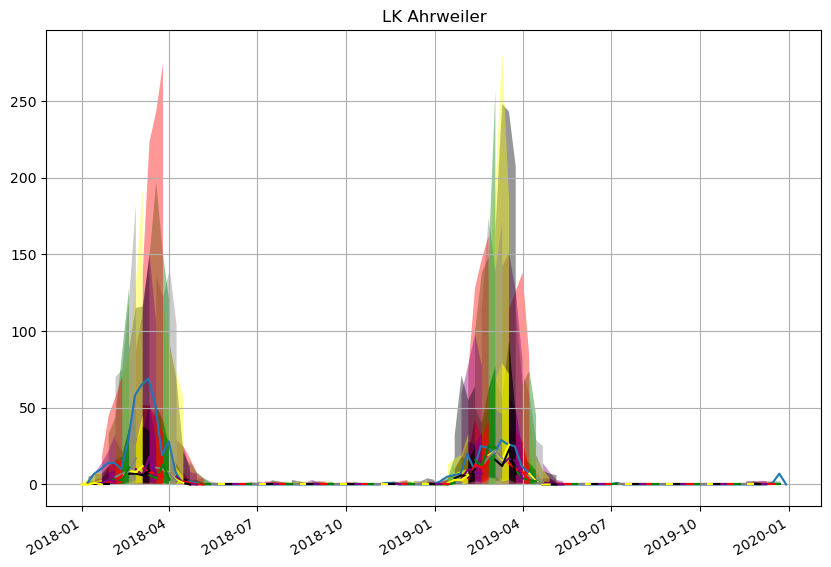

In [30]:
#train and evaluate the model
forecasts, tss = model(config, train_set, test_set, config.deeparestimator)
windows_per_location = int(len(test_set) / len(locations))
for location in locations[:1]:
    #plot the forecasts
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    #first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((one_ts_df.loc[(one_ts_df['location'] == location) &
                            (one_ts_df.index <= config.test_end_time) &
                            (one_ts_df.index >= config.train_end_time)].index),
             one_ts_df.loc[(one_ts_df['location'] == location) &
                           (one_ts_df.index <= config.test_end_time) &
                           (one_ts_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
    #define the colors to use for each different window
    color = ['g', 'r', 'purple', 'black', 'yellow', 'grey'] * windows_per_location
    for k in range(0 + windows_per_location * locations.index(location),
                   windows_per_location + windows_per_location * locations.index(location)):
        ts_entry = tss[k]
        forecast_entry = forecasts[k]
        prediction_intervals = (50.0, 90.0)
        legend = ['train_set observations',"median prediction"] +\
                [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()

100%|██████████| 50/50 [00:02<00:00, 19.07it/s, epoch=8/8, avg_epoch_loss=1.08]
Running evaluation: 411it [00:02, 197.94it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 200.43it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 200.65it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 199.57it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  

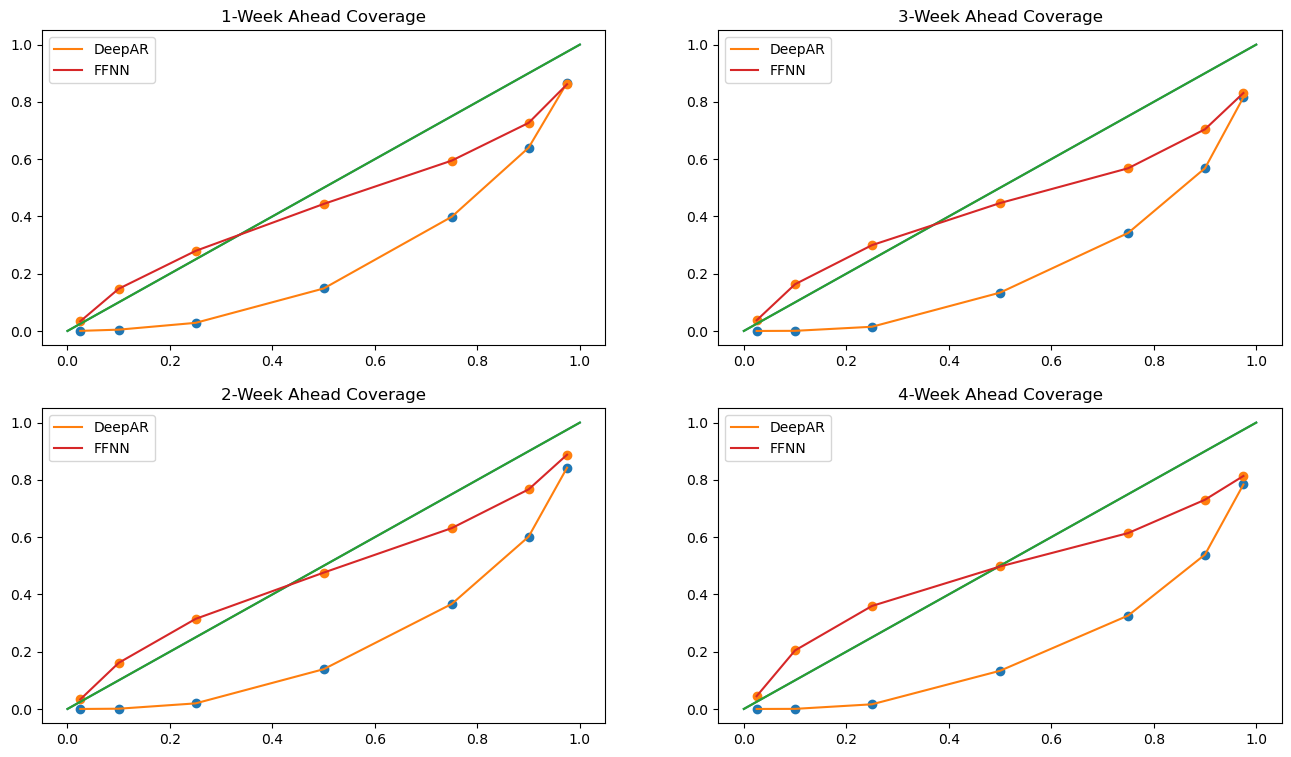

In [31]:
model_dict = {"DeepAR":config.deeparestimator, "FFNN":config.feedforwardestimator}
forecasts_dict, evaluator_df_dict = forecast_by_week(config, train_set, test_set, locations, model_dict)
plot_coverage(config, evaluator_df_dict)

In [32]:
#print(evaluator_df_dict["DeepAR"].loc[evaluator_df_dict["DeepAR"]["wQuantileLoss[0.75]"]>0])
for key in evaluator_df_dict.keys():
    print(key)
    ed = evaluator_df_dict[key].copy()
    print(ed.loc[ed.item_id.isin([item_id for item_id in ed.item_id if "aggregate" in item_id]),])

DeepAR
          item_id forecast_start          MSE  abs_error  abs_target_sum  \
0  aggregated {1}            NaT  1166.374361   380020.0        528449.0   
0  aggregated {2}            NaT  1499.809842   393147.0        528449.0   
0  aggregated {3}            NaT  1762.008095   413981.0        528449.0   
0  aggregated {4}            NaT  2134.504409   437430.0        528449.0   

   abs_target_mean  seasonal_error      MASE      MAPE     sMAPE  ...  \
0        13.255299        1.394398  6.914081  0.959526  1.189894  ...   
0        13.255299        1.394398  7.085233  1.039267  1.226526  ...   
0        13.255299        1.394398  7.371046  1.148485  1.282974  ...   
0        13.255299        1.394398  7.726108  1.300267  1.348084  ...   

   wQuantileLoss[0.25]  wQuantileLoss[0.5]  wQuantileLoss[0.75]  \
0             0.463898            0.719123             0.699444   
0             0.465693            0.743964             0.782171   
0             0.467255            0.783389   

DeepAR


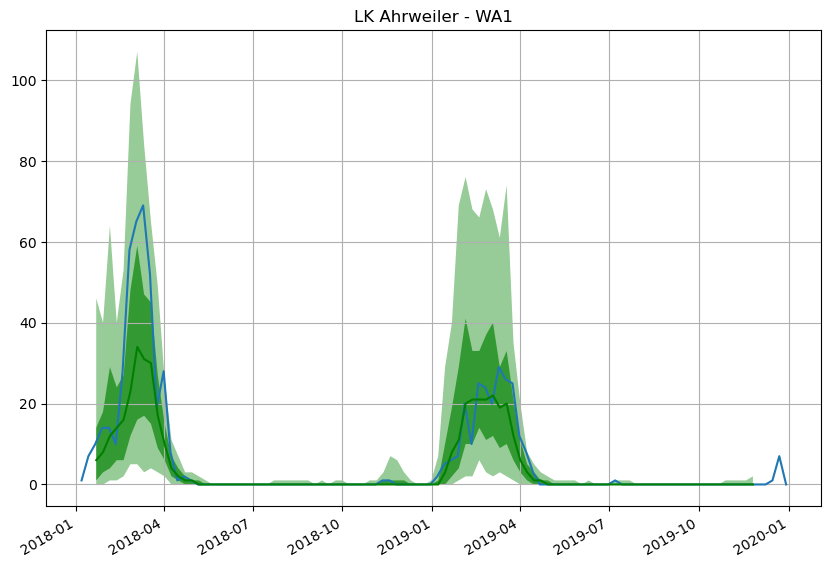

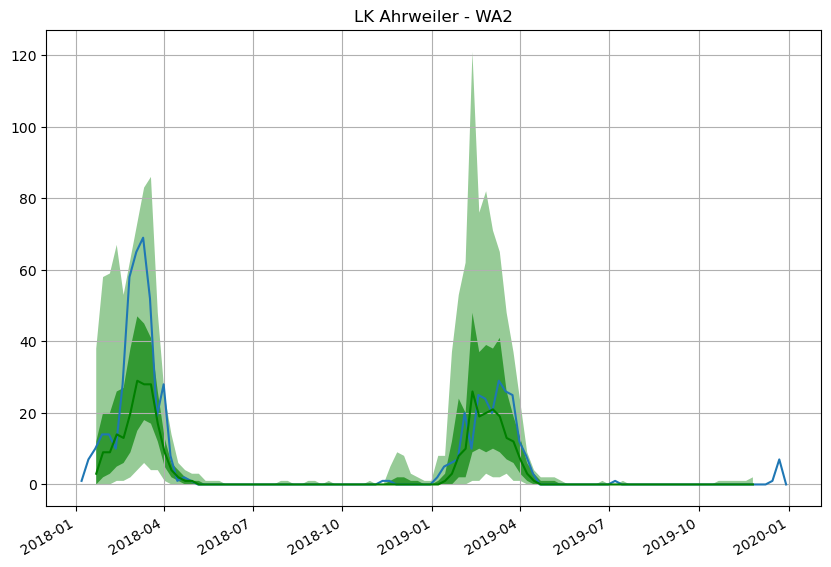

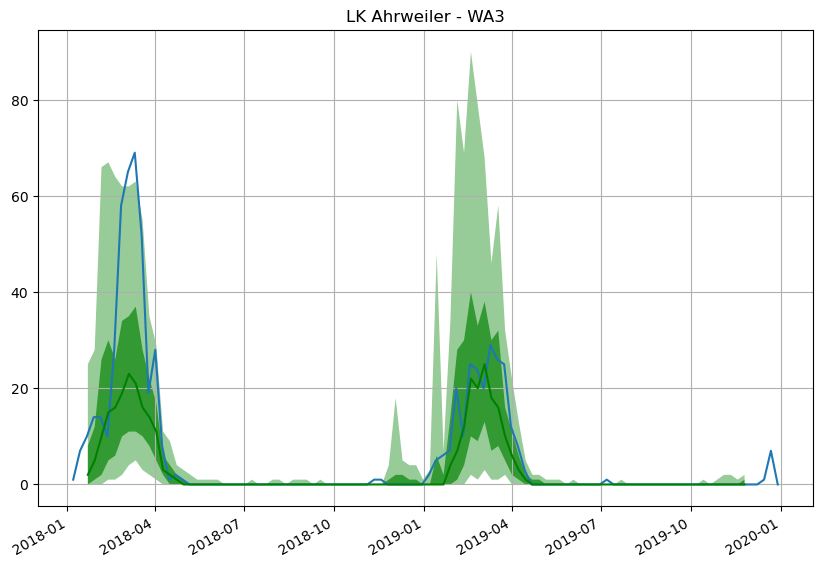

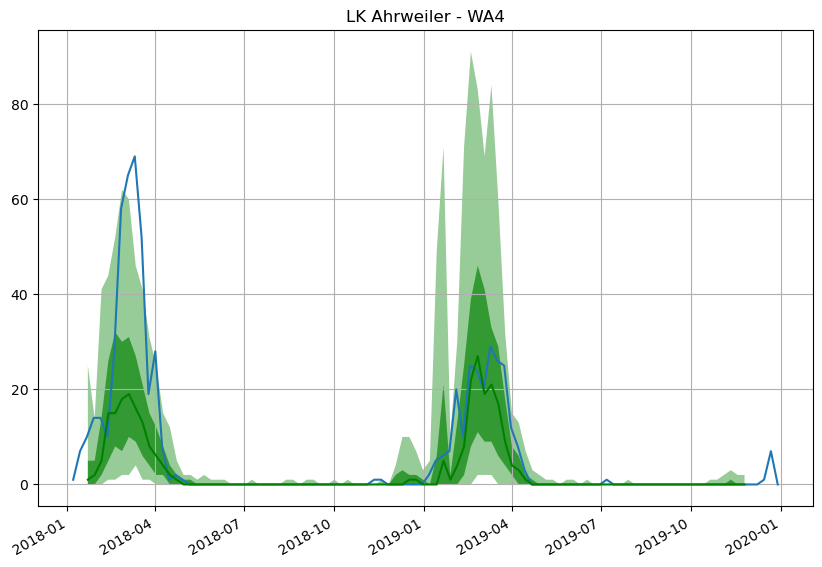

            item_id         forecast_start        MSE  abs_error  \
0  LK Ahrweiler {1}  2018-01-22/2018-01-28  44.137720      262.0   
0  LK Ahrweiler {2}  2018-01-22/2018-01-28  54.973975      276.0   
0  LK Ahrweiler {3}  2018-01-22/2018-01-28  65.582721      304.0   
0  LK Ahrweiler {4}  2018-01-22/2018-01-28  78.591148      352.0   

   abs_target_sum  abs_target_mean  seasonal_error      MASE      MAPE  \
0           594.0         6.123711        0.930952  2.901363  0.518489   
0           594.0         6.123711        0.930952  3.056398  0.520219   
0           594.0         6.123711        0.930952  3.366467  0.550545   
0           594.0         6.123711        0.930952  3.898015  0.639614   

      sMAPE  ...  wQuantileLoss[0.25]  wQuantileLoss[0.5]  \
0  0.780750  ...                  NaN                 NaN   
0  0.799606  ...                  NaN                 NaN   
0  0.884238  ...                  NaN                 NaN   
0  1.038862  ...                  NaN       

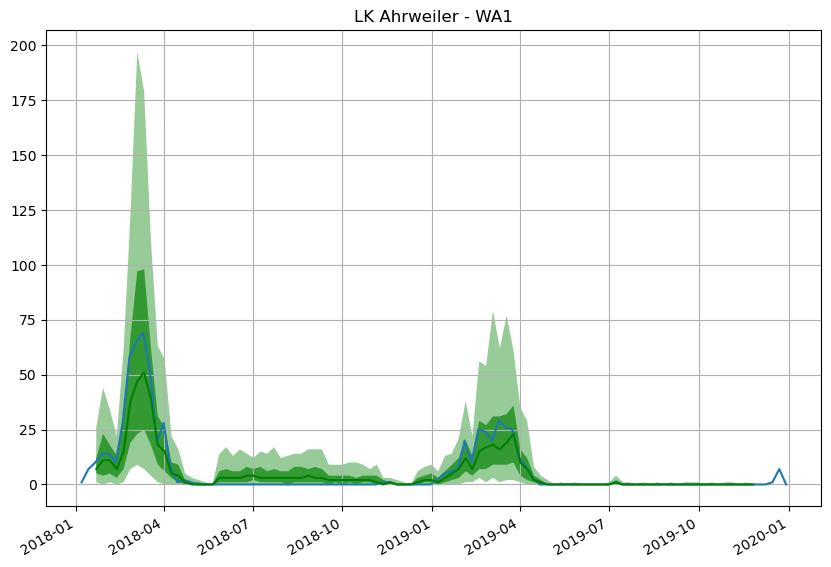

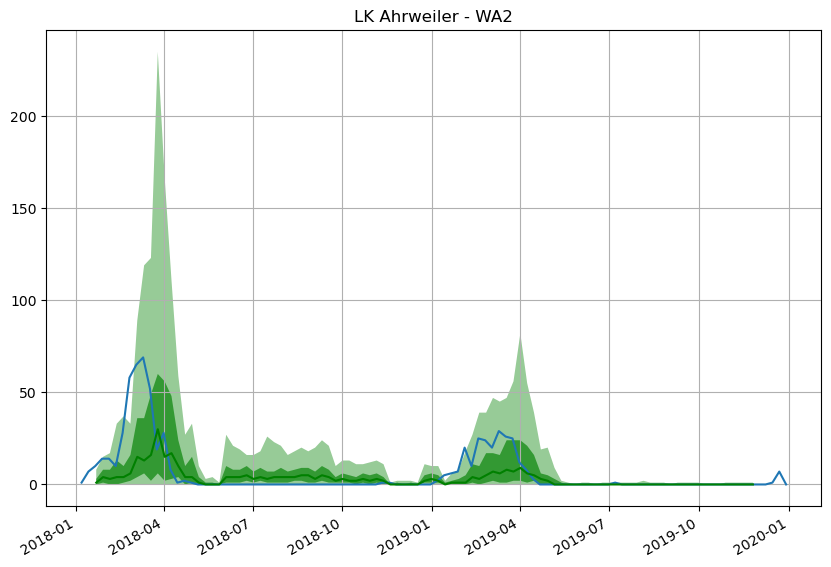

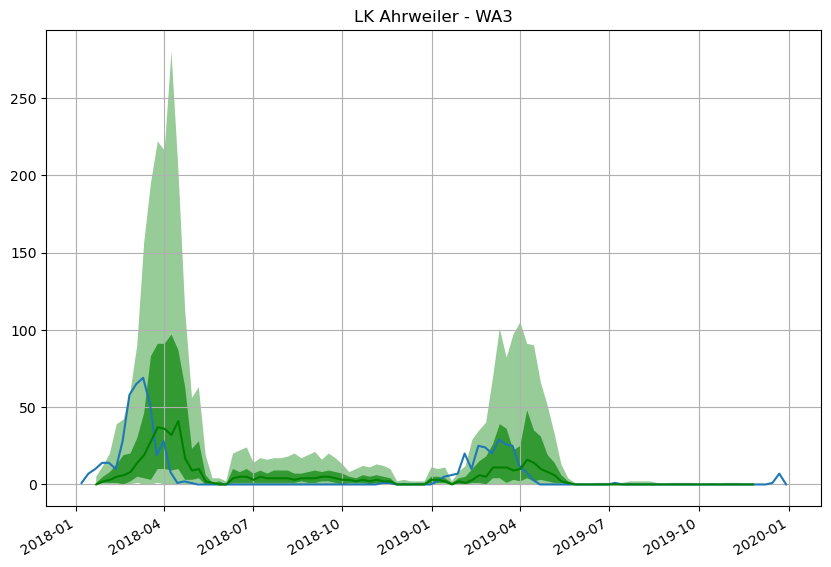

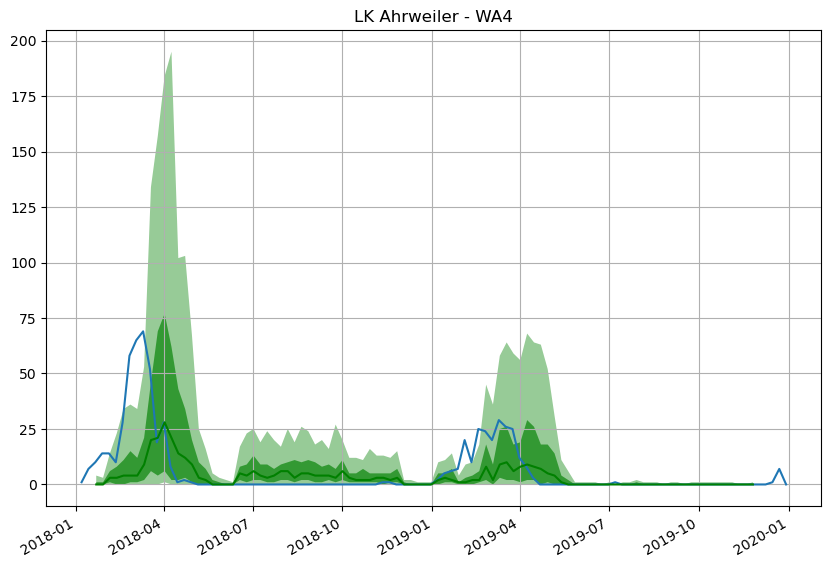

            item_id         forecast_start         MSE  abs_error  \
0  LK Ahrweiler {1}  2018-01-22/2018-01-28   44.002421      341.0   
0  LK Ahrweiler {2}  2018-01-22/2018-01-28  150.985331      568.0   
0  LK Ahrweiler {3}  2018-01-22/2018-01-28  295.787774      695.0   
0  LK Ahrweiler {4}  2018-01-22/2018-01-28  224.167043      653.0   

   abs_target_sum  abs_target_mean  seasonal_error      MASE      MAPE  \
0           594.0         6.123711        0.930952  3.776202  0.610267   
0           594.0         6.123711        0.930952  6.289978  1.428041   
0           594.0         6.123711        0.930952  7.696364  2.959890   
0           594.0         6.123711        0.930952  7.231260  1.994368   

      sMAPE  ...  wQuantileLoss[0.25]  wQuantileLoss[0.5]  \
0  1.280832  ...                  NaN                 NaN   
0  1.555965  ...                  NaN                 NaN   
0  1.593614  ...                  NaN                 NaN   
0  1.635811  ...                  NaN  

In [17]:
for key in list(forecasts_dict.keys()):
        print(key)
        #print_forecasts_by_week(config, one_ts_df, forecasts_dict[key], locations[:1], [1,2,3,4], plot_begin_at_trainstart=False)
        print(evaluator_df_dict[key].loc[evaluator_df_dict[key].item_id.isin([f"{location}"+" {"+f"{i}" + "}" for location in locations[:1] for i in range(1,5)]),:])

# WITH FEATURES

In [18]:
locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
one_ts_df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date','week']]
one_ts_df = preprocessing(config, one_ts_df, check_count=False, output_type="corrected_df")
for location in locations:
    one_ts_df.loc[one_ts_df.location == location, "population"] = int(population_df.loc[population_df.Location == location, "2011"].values[0])
    one_ts_df.loc[one_ts_df.location == location, locations] = neighbourhood_df.loc[neighbourhood_df.index==location,locations].values[0]

In [20]:
#seperate the intervals for training and testing
train_set = one_ts_df.loc[(one_ts_df.index <= config.train_end_time) & (one_ts_df.index >= config.train_start_time), :]
test_set = one_ts_df.loc[(one_ts_df.index >= config.train_start_time) & (one_ts_df.index <= config.test_end_time), :]

start_time = min(test_set.index.difference(train_set.index))
end_time = max(test_set.index.difference(train_set.index))
#Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set, item_id='location', target="value", freq=config.freq,
                                              feat_static_real=["population"]+locations, feat_dynamic_real=["week"])
test_set = PandasDataset.from_long_dataframe(dataframe=test_set, item_id='location', target="value", freq=config.freq,
                                             feat_static_real=["population"]+locations, feat_dynamic_real=["week"])

test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy=StepStrategy(prediction_length=4,step_size=1),
                                    start_time=pd.Period(start_time,config.freq),
                                    end_time=pd.Period(end_time,config.freq)
                                    )

100%|██████████| 50/50 [00:25<00:00,  1.99it/s, epoch=8/8, avg_epoch_loss=0.868]
Running evaluation: 411it [00:01, 215.03it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 218.27it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 214.07it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 216.29it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
 

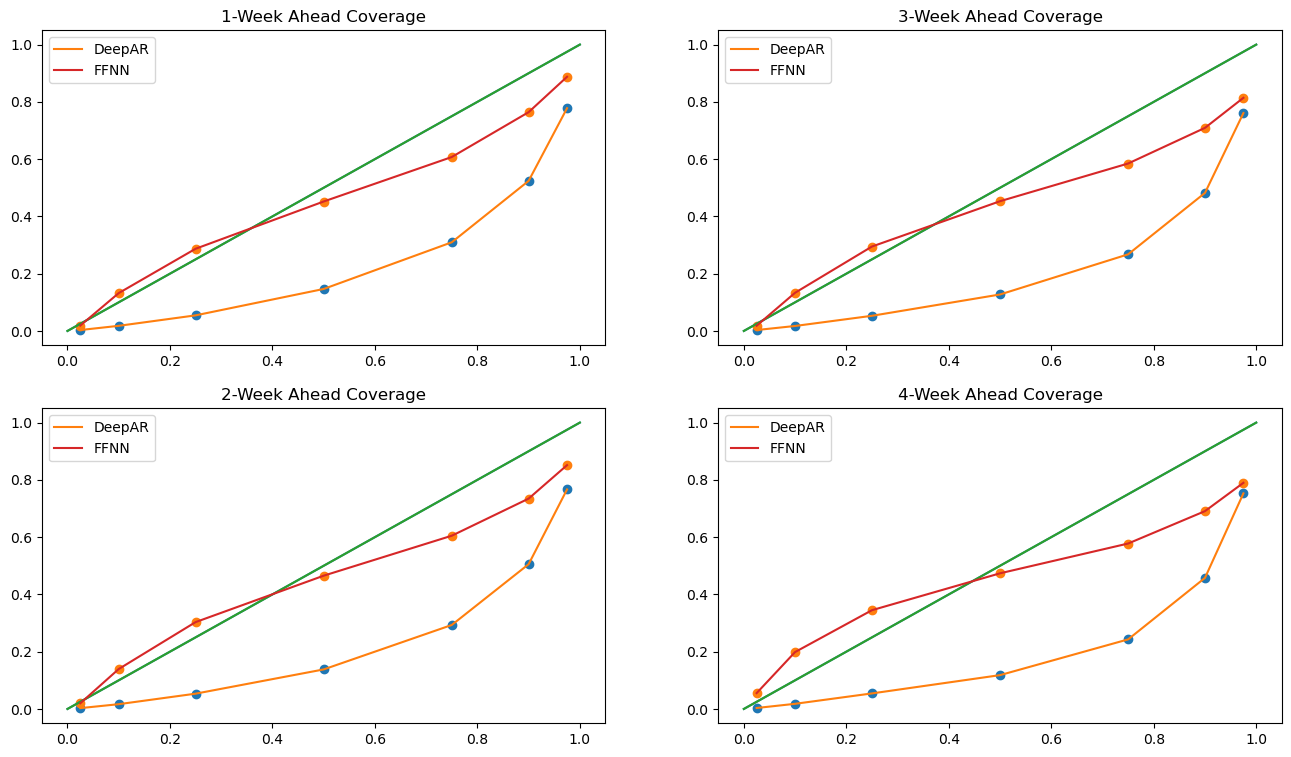

In [22]:
model_dict = {"DeepAR":config.deeparestimator, "FFNN":config.feedforwardestimator}
forecasts_dict, evaluator_df_dict = forecast_by_week(config, train_set, test_set, locations, model_dict)
plot_coverage(config, evaluator_df_dict)

In [ ]:
coverage_cols = ['Coverage[0.1]', 'Coverage[0.25]','Coverage[0.5]','Coverage[0.75]', 'Coverage[0.9]']
for key in list(forecasts_dict.keys()):
        print(key)
        print_forecasts_by_week(config, one_ts_df, forecasts_dict[key], locations[:1], [1,2,3,4], plot_begin_at_trainstart=False)
        print(evaluator_df_dict[key].loc[evaluator_df.item_id.isin([f"{location}"+" {"+f"{i}" + "}" for location in locations[:1] for i in range(1,5)]),['item_id']+coverage_cols])

In [24]:
#print(evaluator_df_dict["DeepAR"].loc[evaluator_df_dict["DeepAR"]["wQuantileLoss[0.75]"]>0])
for key in evaluator_df_dict.keys():
    print(key)
    ed = evaluator_df_dict[key].copy()
    print(ed.loc[ed.item_id.isin([item_id for item_id in ed.item_id if "aggregate" in item_id]),])

DeepAR
          item_id forecast_start          MSE  abs_error  abs_target_sum  \
0  aggregated {1}            NaT   713.691158   292201.0        528449.0   
0  aggregated {2}            NaT   918.311608   327261.0        528449.0   
0  aggregated {3}            NaT  1152.305140   369694.0        528449.0   
0  aggregated {4}            NaT  1394.419266   409977.0        528449.0   

   abs_target_mean  seasonal_error      MASE      MAPE     sMAPE  ...  \
0        13.255299        1.394398  5.401679  0.857864  0.989955  ...   
0        13.255299        1.394398  5.912253  0.960646  1.081921  ...   
0        13.255299        1.394398  6.612799  1.094044  1.191996  ...   
0        13.255299        1.394398  7.295722  1.216164  1.291192  ...   

   wQuantileLoss[0.25]  wQuantileLoss[0.5]  wQuantileLoss[0.75]  \
0             0.370409            0.552941             0.507434   
0             0.392373            0.619286             0.600775   
0             0.422863            0.699583   

In [ ]:
print([f"{location}"+f" {i}" for location in locations[:3] for i in range(1,5)])

In [ ]:
coverage_cols = ['Coverage[0.1]', 'Coverage[0.25]','Coverage[0.5]','Coverage[0.75]', 'Coverage[0.9]']
for location in locations[:5]:
    print(location)
    print(evaluator_df_dict["DeepAR"].loc[evaluator_df.item_id.isin([f"{location}"+" {1}", f"{location}"+" {2}", f"{location}"+" {3}", f"{location}"+" {4}"]),['item_id']+coverage_cols])

# Try out the full predictive horizon for training

In [33]:
locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
one_ts_df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date','week']]
one_ts_df = preprocessing(config, one_ts_df, check_count=False, output_type="corrected_df")
for location in locations:
    one_ts_df.loc[one_ts_df.location == location, "population"] = int(population_df.loc[population_df.Location == location, "2011"].values[0])
    one_ts_df.loc[one_ts_df.location == location, locations] = neighbourhood_df.loc[neighbourhood_df.index==location,locations].values[0]

In [40]:
#seperate the intervals for training and testing
train_set = one_ts_df.loc[(one_ts_df.index <= config.train_end_time), :]
test_set = one_ts_df.loc[(one_ts_df.index <= config.test_end_time), :]

start_time = min(test_set.index.difference(train_set.index))
end_time = max(test_set.index.difference(train_set.index))
#Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set, item_id='location', target="value", freq=config.freq,
                                              feat_static_real=["population"]+locations, feat_dynamic_real=["week"])
test_set = PandasDataset.from_long_dataframe(dataframe=test_set, item_id='location', target="value", freq=config.freq,
                                             feat_static_real=["population"]+locations, feat_dynamic_real=["week"])

test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy=StepStrategy(prediction_length=config.prediction_length,step_size=1),
                                    start_time=pd.Period(start_time,config.freq),
                                    end_time=pd.Period(end_time,config.freq)
                                    )

100%|██████████| 50/50 [00:26<00:00,  1.88it/s, epoch=8/8, avg_epoch_loss=1.02]
Running evaluation: 411it [00:02, 197.49it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 192.86it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 195.06it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:02, 195.51it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  

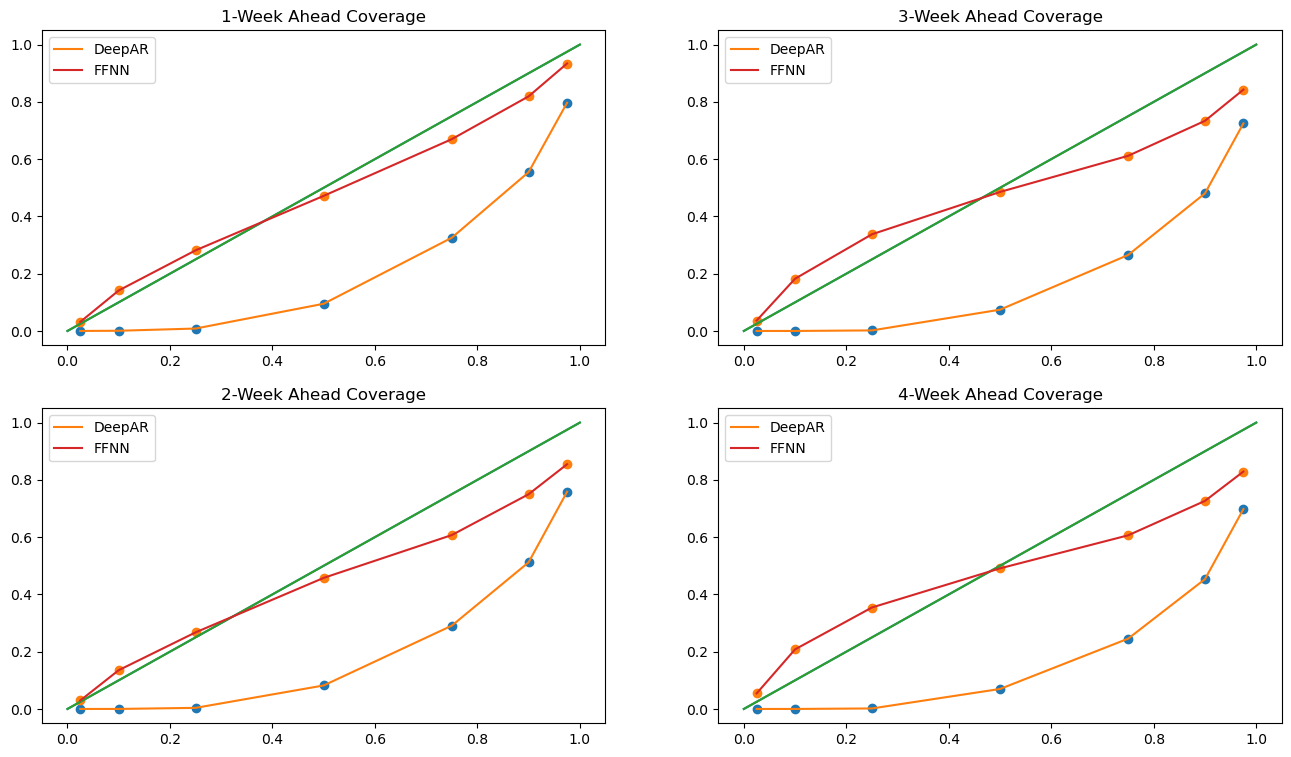

In [35]:
model_dict = {"DeepAR":config.deeparestimator, "FFNN":config.feedforwardestimator}
forecasts_dict, evaluator_df_dict = forecast_by_week(config, train_set, test_set, locations, model_dict)
plot_coverage(config, evaluator_df_dict)

In [36]:
for key in evaluator_df_dict.keys():
    print(key)
    ed = evaluator_df_dict[key].copy()
    print(ed.loc[ed.item_id.isin([item_id for item_id in ed.item_id if "aggregate" in item_id]),])

DeepAR
          item_id forecast_start          MSE  abs_error  abs_target_sum  \
0  aggregated {1}            NaT  1210.739561   424420.0        528449.0   
0  aggregated {2}            NaT  1495.315847   446426.0        528449.0   
0  aggregated {3}            NaT  1829.882709   467768.0        528449.0   
0  aggregated {4}            NaT  2093.556889   483795.0        528449.0   

   abs_target_mean  seasonal_error  MASE      MAPE     sMAPE  ...  \
0        13.255299         5.39781   inf  0.850895  1.420327  ...   
0        13.255299         5.39781   inf  0.864059  1.475251  ...   
0        13.255299         5.39781   inf  0.904067  1.537003  ...   
0        13.255299         5.39781   inf  0.948021  1.583970  ...   

   wQuantileLoss[0.25]  wQuantileLoss[0.5]  wQuantileLoss[0.75]  \
0             0.483515            0.803143             0.865739   
0             0.488588            0.844785             0.999902   
0             0.492322            0.885172             1.128484  

DeepAR


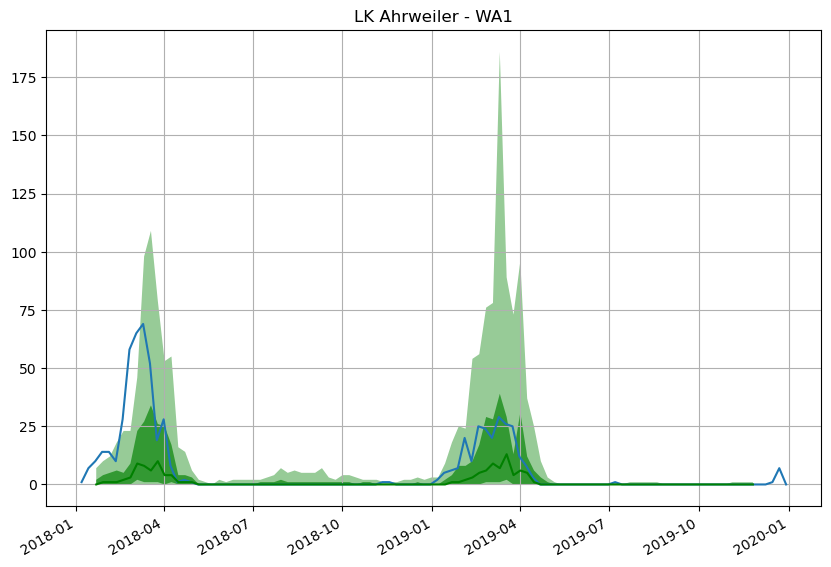

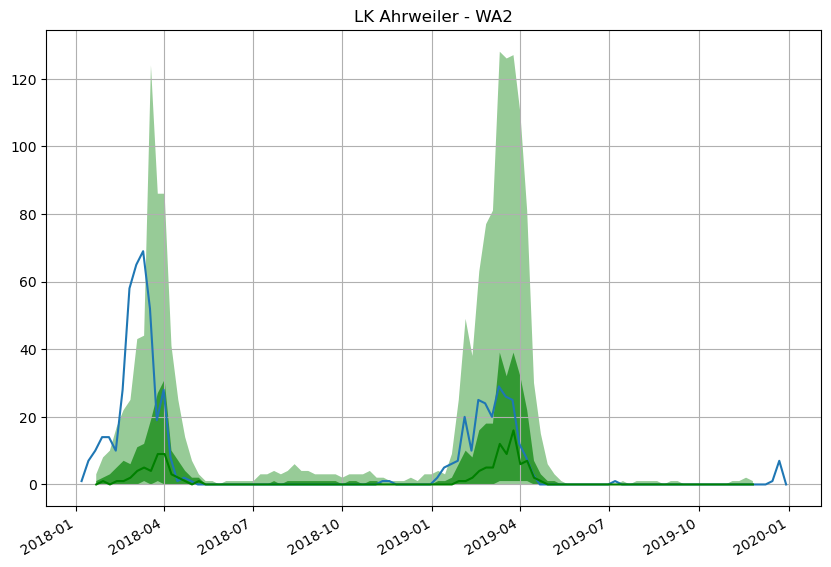

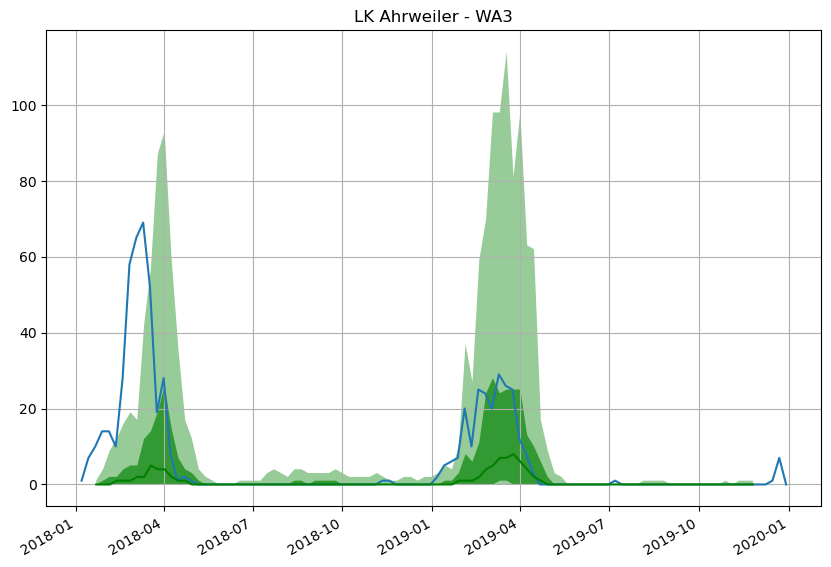

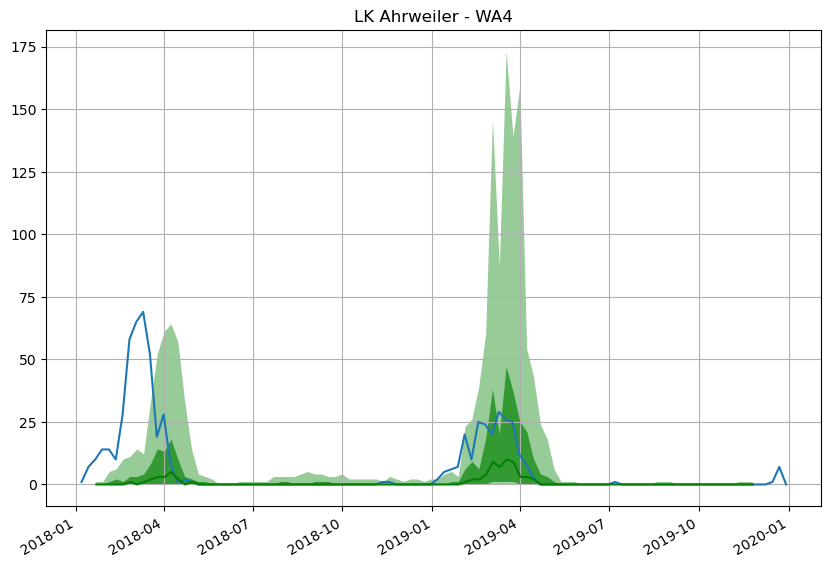

FFNN


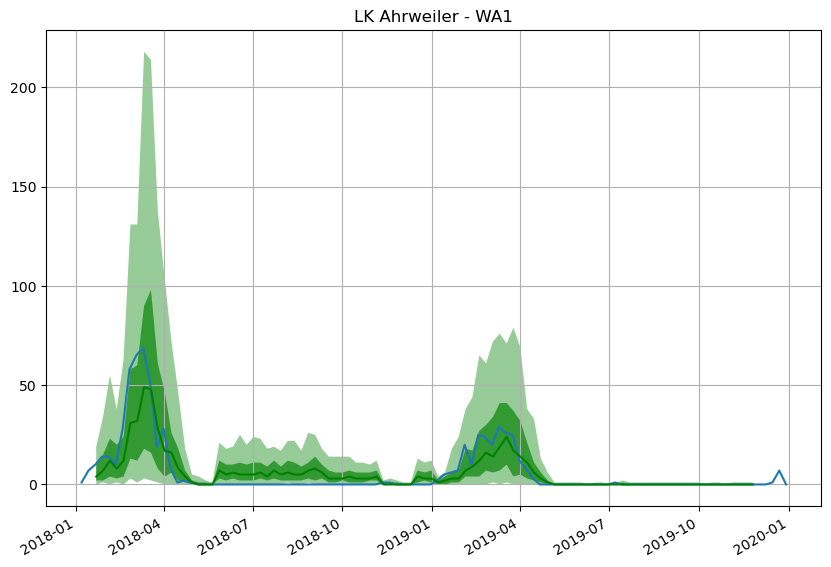

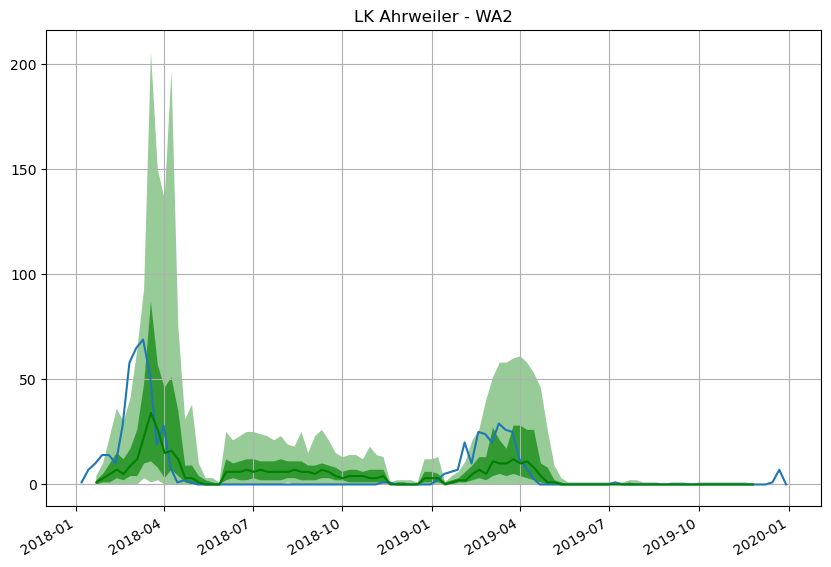

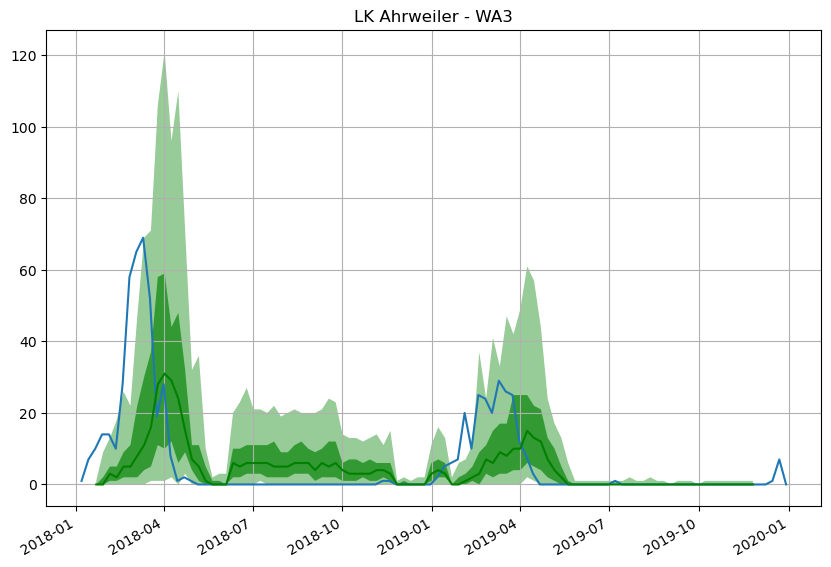

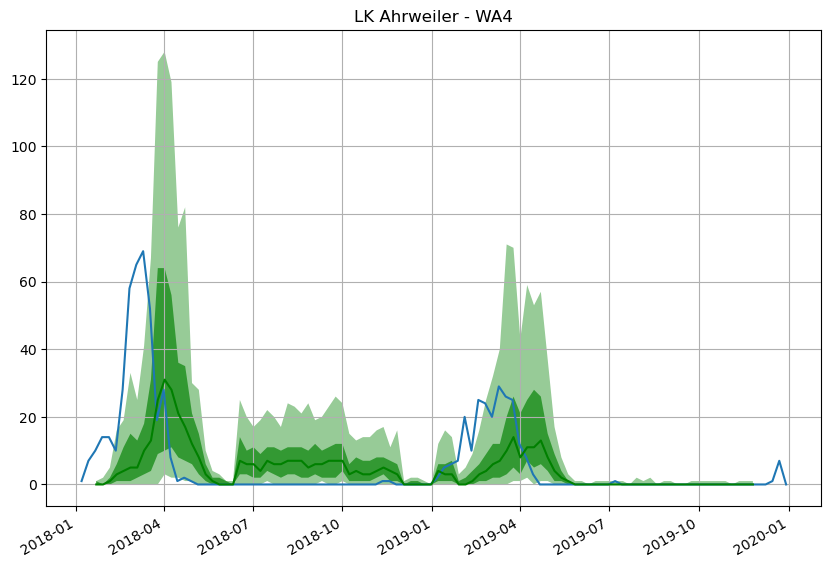

In [37]:
for key in list(forecasts_dict.keys()):
        print(key)
        print_forecasts_by_week(config, one_ts_df, forecasts_dict[key], locations[:1], [1,2,3,4], plot_begin_at_trainstart=False)